In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import nibabel as nib
import SimpleITK as sitk
from typing import List
from utils.general_utils import plot_imgs, plot_sitk_img, save_sitk_from_nda
from utils.utils import save_nifti_from_array, crop_img, obtain_brain_mask
import cc3d
import json
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure

# import torch
# import torchvision

this_path = Path().resolve()
pilot_path = Path("/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/segmentations")

2023-03-13 12:29:10,781 - Created a temporary directory at /tmp/tmpgjz5g2q6
2023-03-13 12:29:10,783 - Writing /tmp/tmpgjz5g2q6/_remote_module_non_scriptable.py
/home/alejandrocu/Documents/parkinson_classification/models/medicalnet


In [ ]:
def get_brainstem_mask(subject):
    synthseg_path = pilot_path / 'seg_msub-003_ses-01prisma3t_echo-01_part-magnitude-acq-T1w_MPM.nii'
    synthseg = sitk.ReadImage(str(synthseg_path))
    synthseg_nda = sitk.GetArrayFromImage(synthseg)
    # obtain brainstem mask from list of labels
    labels = [16, # brainstem
              28, # left ventral DC
              60, # right ventral DC
              
              ]



In [2]:
def mask_maps(subject):
    anat_path = Path(f'/mnt/scratch/7TPD/mpm_run_acu/bids/{subject}/ses-01prisma3t/anat')
    pilot_path = Path(f"/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/{subject}/Results")
    # read brain mask
    brain_mask = sitk.GetArrayFromImage(sitk.ReadImage(str(anat_path/f'reoriented_brain_mask.nii')))
    # dilate the mask
    brain_mask = binary_dilation(brain_mask, generate_binary_structure(3, 1), iterations=2).astype(brain_mask.dtype)

    x_min, x_max, y_min, y_max, z_min, z_max = crop_img(brain_mask, return_dims=True)
    # process each map
    for map_name in ['MTsat_w', 'PD_R2scorr_w', 'R1_w', 'R2s_WLS1_w']:
        sitk_map = sitk.ReadImage(str(pilot_path/f'{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_{map_name}.nii'))
        map_nda = sitk.GetArrayFromImage(sitk_map)
        # apply mask
        map_nda = map_nda * brain_mask
        # crop map
        map_nda_c = map_nda[x_min:x_max, y_min:y_max, z_min:z_max]
        # save map
        save_sitk_from_nda(map_nda_c, 
                           pilot_path/f'{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_{map_name}_masked.nii', 
                           sitk_map)

In [3]:
# Set data directory
root_dir = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
subj_ids = md_df['id'].values
subj_ids = np.delete(subj_ids, np.where(subj_ids == 'sub-058'))

for subj in list(subj_ids):
    mask_maps(subj)
    print(subj)

sub-003
sub-004
sub-005
sub-006
sub-007
sub-008
sub-009
sub-010
sub-011
sub-012
sub-013
sub-014
sub-015
sub-016
sub-017
sub-018
sub-019
sub-020
sub-021
sub-022
sub-023
sub-024
sub-025
sub-026
sub-027
sub-028
sub-029
sub-030
sub-031
sub-032
sub-033
sub-034
sub-035
sub-036
sub-037
sub-038
sub-039
sub-040
sub-041
sub-042
sub-043
sub-044
sub-045
sub-046
sub-047
sub-048
sub-049
sub-050
sub-051
sub-052
sub-053
sub-054
sub-055
sub-056
sub-057
sub-059
sub-060
sub-061
sub-062
sub-063
sub-064
sub-065
sub-066
sub-067
sub-068
sub-069
sub-070
sub-071
sub-072
sub-073
sub-074


In [33]:
sitk_map = sitk.ReadImage(str(pilot_path/f'Results/{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_MTsat_w_masked.nii'))

np.asarray(sitk_map.GetSize())

array([194, 163, 158])

In [4]:
dims = np.zeros((len(subj_ids), 4))
map_name = 'MTsat_w'
for i, subject in enumerate(subj_ids):
    pilot_path = Path(f"/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/{subject}/Results")
    sitk_map = sitk.ReadImage(str(pilot_path/f'{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_{map_name}_masked.nii'))
    dims[i, :-1] = np.asarray(sitk_map.GetSize())
    dims[i, -1] = int(subject.split('-')[-1])

In [5]:
print('min', np.min(dims, axis=0))
print('max', np.max(dims, axis=0))

min [163. 132.  80.   3.]
max [211. 177. 173.  74.]


In [43]:
subj_ids[43]

'sub-046'

In [6]:
dims

array([[178., 170., 158.,   3.],
       [193., 164., 169.,   4.],
       [196., 170., 154.,   5.],
       [182., 164., 156.,   6.],
       [183., 157., 154.,   7.],
       [195., 167., 162.,   8.],
       [171., 146., 141.,   9.],
       [179., 167., 144.,  10.],
       [186., 177., 166.,  11.],
       [186., 162., 156.,  12.],
       [191., 168., 158.,  13.],
       [176., 161., 155.,  14.],
       [188., 160., 153.,  15.],
       [189., 174., 162.,  16.],
       [178., 175., 171.,  17.],
       [189., 173., 165.,  18.],
       [188., 162., 154.,  19.],
       [194., 156., 163.,  20.],
       [192., 162., 153.,  21.],
       [187., 162., 164.,  22.],
       [188., 162., 158.,  23.],
       [193., 168., 161.,  24.],
       [170., 132.,  80.,  25.],
       [173., 157., 151.,  26.],
       [180., 159., 150.,  27.],
       [184., 153., 154.,  28.],
       [210., 174., 164.,  29.],
       [163., 135., 139.,  30.],
       [185., 156., 153.,  31.],
       [191., 169., 166.,  32.],
       [20

In [19]:
subject = 'sub-074'
anat_path = Path(f'/mnt/scratch/7TPD/mpm_run_acu/bids/{subject}/ses-01prisma3t/anat')
pilot_path = Path(f"/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/{subject}/")
# read MT map
mtw_map = sitk.GetArrayFromImage(sitk.ReadImage(str(pilot_path/f'Results/{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_MTsat_w.nii')))
# read brain mask
brain_mask = sitk.GetArrayFromImage(sitk.ReadImage(str(anat_path/f'reoriented_brain_mask.nii')))
# mask volume
# mtw_map_masked = sitk.Mask(mtw_map, brain_mask, maskingValue=1, outsideValue=0)

# dilating the brain mask
iterations = 3
struct1 = generate_binary_structure(3, 1)
struct2 = generate_binary_structure(3, 2)
brain_mask_dilated1 = binary_dilation(brain_mask, structure=struct1, iterations=iterations-1).astype(brain_mask.dtype)
brain_mask_dilated2 = binary_dilation(brain_mask, structure=struct1, iterations=iterations).astype(brain_mask.dtype)

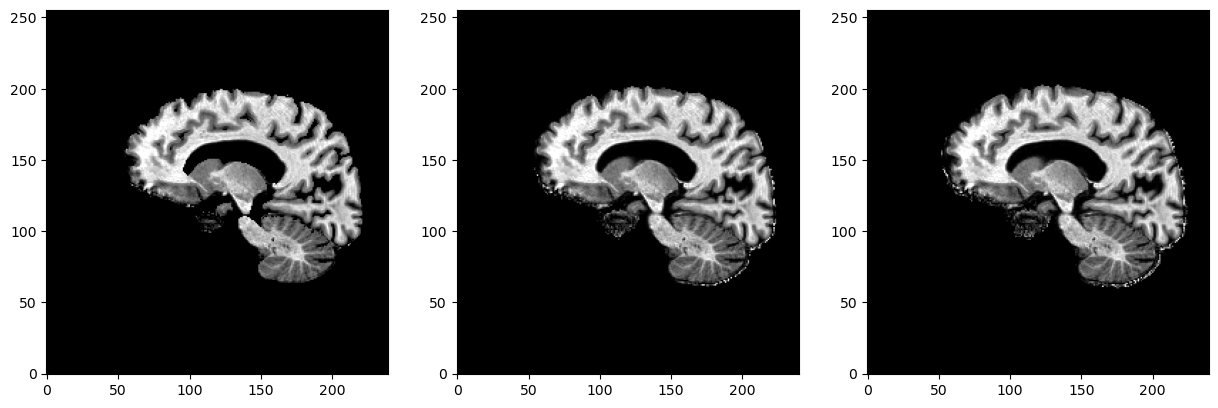

In [20]:
mtw_map_masked_o = mtw_map * brain_mask
mtw_map_masked1 = mtw_map * brain_mask_dilated1
mtw_map_masked2 = mtw_map * brain_mask_dilated2
f, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(mtw_map_masked_o[100, :, :], cmap='gray', origin='lower')
axs[1].imshow(mtw_map_masked1[100, :, :], cmap='gray', origin='lower')
axs[2].imshow(mtw_map_masked2[100, :, :], cmap='gray', origin='lower')

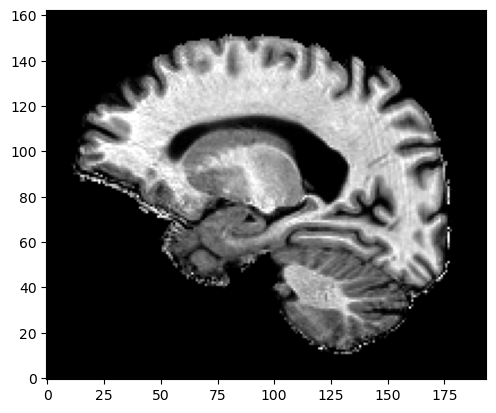

In [22]:
mtw_masked1_cropped = crop_img(mtw_map_masked1)
plt.imshow(mtw_masked1_cropped[100, :, :], cmap='gray', origin='lower')

In [23]:
save_sitk_from_nda(mtw_masked1_cropped, 
                   pilot_path/f'Results/{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_MTsat_w_masked.nii',
                   sitk.ReadImage(str(pilot_path/f'Results/{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_MTsat_w.nii')))

#### DEv

In [102]:
brain_mask, masks_path = obtain_brain_mask('sub-004')
sitk_img = sitk.ReadImage(str(masks_path/f'msub-004_ses-01prisma3t_echo-01_part-magnitude-acq-T1w_MPM.nii'))
save_sitk_from_nda(brain_mask, masks_path/'brain_mask.nii', sitk_img)

In [110]:
# Set data directory
root_dir = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
subj_ids = md_df['id'].values
subj_ids = np.delete(subj_ids, np.where(subj_ids == 'sub-058'))

In [114]:
for subj in list(subj_ids):
    brain_mask, masks_path = obtain_brain_mask(subj)
    sitk_img = sitk.ReadImage(str(masks_path/f'm{subj}_ses-01prisma3t_echo-01_part-magnitude-acq-T1w_MPM.nii'))
    save_sitk_from_nda(brain_mask, masks_path/'brain_mask.nii', sitk_img)
    print(subj)

sub-003
sub-004
sub-005
sub-006
sub-007
sub-008
sub-009
sub-010
sub-011
sub-012
sub-013
sub-014
sub-015
sub-016
sub-017
sub-018
sub-019
sub-020
sub-021
sub-022
sub-023
sub-024
sub-025
sub-026
sub-027
sub-028
sub-029
sub-030
sub-031
sub-032
sub-033
sub-034
sub-035
sub-036
sub-037
sub-038
sub-039
sub-040
sub-041
sub-042
sub-043
sub-044
sub-045
sub-046
sub-047
sub-048
sub-049
sub-050
sub-051
sub-052
sub-053
sub-054
sub-055
sub-056
sub-057
sub-059
sub-060
sub-061
sub-062
sub-063
sub-064
sub-065
sub-066
sub-067
sub-068
sub-069
sub-070
sub-071
sub-072
sub-073
sub-074


In [124]:
# reading and writing transformation matrix from json file
for subj in list(subj_ids):
    root_dir = f'/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/{subj}/AutoReorient'
    json_obj = json.load(open(f'{root_dir}/AutoReorient_output.json'))
    m_matrix = np.asarray(json_obj['M'])
    np.savetxt(root_dir + '/m_matrix.csv', m_matrix, delimiter=',')
    print(subj)

sub-003
sub-004
sub-005
sub-006
sub-007
sub-008
sub-009
sub-010
sub-011
sub-012
sub-013
sub-014
sub-015
sub-016
sub-017
sub-018
sub-019
sub-020
sub-021
sub-022
sub-023
sub-024
sub-025
sub-026
sub-027
sub-028
sub-029
sub-030
sub-031
sub-032
sub-033
sub-034
sub-035
sub-036
sub-037
sub-038
sub-039
sub-040
sub-041
sub-042
sub-043
sub-044
sub-045
sub-046
sub-047
sub-048
sub-049
sub-050
sub-051
sub-052
sub-053
sub-054
sub-055
sub-056
sub-057
sub-059
sub-060
sub-061
sub-062
sub-063
sub-064
sub-065
sub-066
sub-067
sub-068
sub-069
sub-070
sub-071
sub-072
sub-073
sub-074


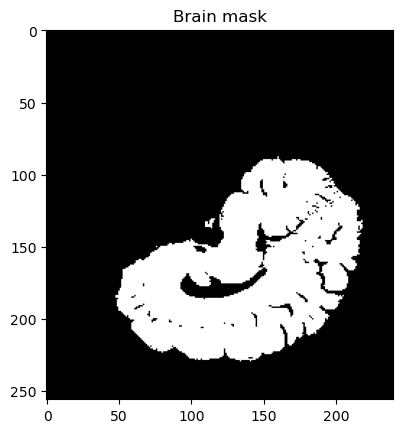

In [57]:
masks_path = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/sub-005/ses-01prisma3t/anat')

# get segmentation labels from all atlas
base_str = 'sub-005_ses-01prisma3t_echo-01_part-magnitude-acq-T1w_MPM.nii'
volumes = []
for cl in ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']:
    img = sitk.ReadImage(str(masks_path/f'{cl}{base_str}'))
    volumes.append(sitk.GetArrayFromImage(img))

volumes_nda = np.stack(volumes, axis=0)
labels = np.argmax(volumes_nda, axis=0)
brain_mask = np.int16(labels < 2)
plot_sitk_img(sitk.GetImageFromArray(brain_mask), title='Brain mask')

In [66]:
labels_out, N = cc3d.connected_components(brain_mask, return_N=True)

In [93]:
labels_out_k, N_k = cc3d.largest_k(labels_out, k=1, return_N=True)
N_k

1

In [94]:
np.unique(labels_out_k, return_counts=True)

(array([0, 1], dtype=uint16), array([9514327, 1299113]))

In [68]:
np.unique(labels_out, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       dtype=uint16),
 array([9510754, 1299113,       1,    1845,       1,       1,       1,
           1718,       1,       1,       1,       1,       1,       1]))

In [90]:
np.bincount(labels_out.flatten())

array([9510754, 1299113,       1,    1845,       1,       1,       1,
          1718,       1,       1,       1,       1,       1,       1])

In [95]:
brain_mask_filtered = np.int16(labels_out_k == 1)

In [71]:
sitk_img = sitk.ReadImage(str(masks_path/f'm{base_str}'))
save_sitk_from_nda(brain_mask_filtered, masks_path/'brain_maskCC.nii', sitk_img)

In [82]:
brain_mask_filtered.shape

(176, 256, 240)

In [96]:
bm_cropped = crop_img(brain_mask_filtered)
bm_cropped.shape

(150, 166, 192)

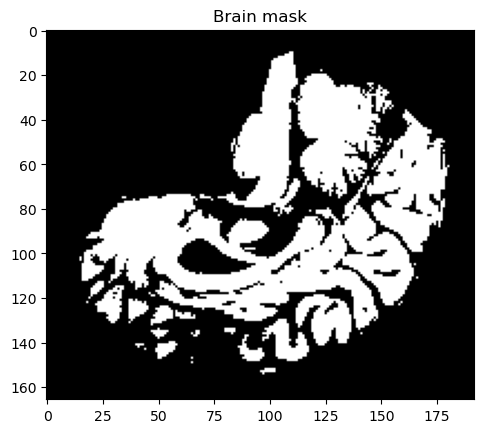

In [97]:
plot_sitk_img(sitk.GetImageFromArray(bm_cropped), slice=75, title='Brain mask')

In [89]:
save_sitk_from_nda(bm_cropped, masks_path/'brain_mask_cropped.nii', sitk_img)

In [75]:
points = np.where(brain_mask_filtered == 1)
points

(array([ 23,  23,  23, ..., 152, 152, 153]),
 array([138, 139, 139, ..., 165, 165, 141]),
 array([131, 131, 133, ..., 146, 147, 130]))

In [76]:
np.argwhere(brain_mask_filtered == 1)

array([[ 23, 138, 131],
       [ 23, 139, 131],
       [ 23, 139, 133],
       ...,
       [152, 165, 146],
       [152, 165, 147],
       [153, 141, 130]])

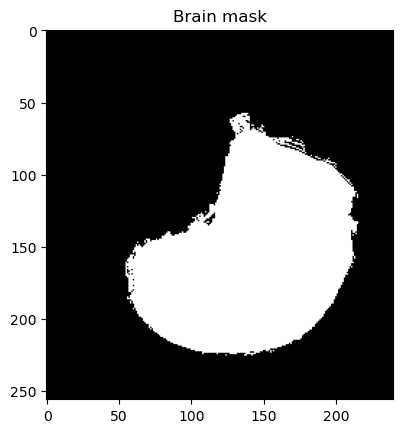

In [47]:
brain_mask = np.int16(labels < 3)
plot_sitk_img(sitk.GetImageFromArray(brain_mask), title='Brain mask')

In [44]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([ 595746,  443152,  532264,  787311, 2799821, 5655146]))

In [3]:
masks_path = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/sub-003/ses-01prisma3t/anat')
gm_mask = sitk.ReadImage(str(masks_path/'c1sub-003_ses-01prisma3t_echo-01_part-magnitude-acq-T1w_MPM.nii'))
wm_mask = sitk.ReadImage(str(masks_path/'c2sub-003_ses-01prisma3t_echo-01_part-magnitude-acq-T1w_MPM.nii'))
t1_img = sitk.ReadImage(str(masks_path/'msub-003_ses-01prisma3t_echo-01_part-magnitude-acq-T1w_MPM.nii'))
mtw_map = sitk.ReadImage(str(pilot_path/'Results/sub-003_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_MTsat_w.nii'))

# t1_img_masked = sitk.Mask(t1_img, gm_mask)

In [36]:
gm_mask_nda = np.flip(np.transpose(sitk.GetArrayFromImage(gm_mask), (1, 2, 0)), axis=0)
gm_mask_nda.min(), gm_mask_nda.max()

(0.0, 0.9843138)

In [40]:
volume = np.stack([gm_mask_nda, gm_mask_nda, gm_mask_nda], axis=0)
volume.shape

(3, 256, 240, 176)

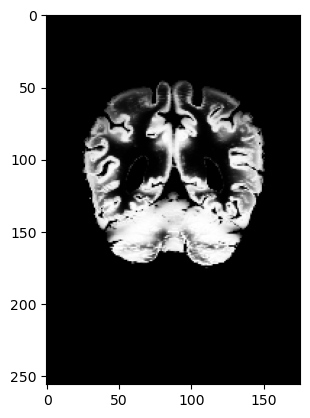

In [38]:
plt.imshow(gm_mask_nda[:,170,:], cmap='gray')

In [29]:
mask = gm_mask>0
mask.GetSize()

(240, 256, 176)

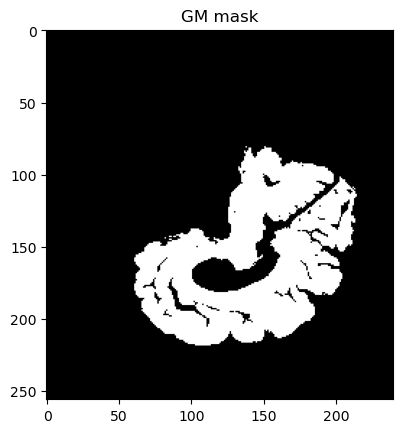

In [30]:
plot_sitk_img(mask, title='GM mask')